In [1]:
from evaluate import *
from s_learner import *
from t_learner import *
from tarnet import *
from efin import *
from functools import partial
from esn_tarnet import *
from feature_select import *
from x_learner import *
from descn import *
import shap
import torch
import torch.nn as nn

def set_seed(seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(42)


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [3]:
#读取特征列表
import pickle
with open('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/feature_list_bonus_pdp_id_selected.pkl', 'rb') as f:
    feature_list = pickle.load(f)
print(len(feature_list))

100


In [4]:
#读取特征列表
import pickle
with open('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/feature_list_bonus_pdp_id_selected_discrete.pkl', 'rb') as f:
    feature_list_discrete = pickle.load(f)
print(len(feature_list_discrete))

33


In [5]:
#读取特征列表
# !rm -r /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/feature_list_bonus_pdp_id.pkl
# !hdfs dfs -get /home/byte_ecom_product_ds/feature_list_bonus_pdp_id.pkl /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/
import pickle
with open('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/feature_list_bonus_pdp_id_selected_discrete_size.pkl', 'rb') as f:
    discrete_size_cols = pickle.load(f)
print(discrete_size_cols)

[5, 5, 26, 32, 5, 4, 33, 4, 4, 4, 9, 12, 4, 11, 4, 8, 33, 8, 35, 3, 5, 4, 5, 10, 9, 4, 15, 33, 4, 17, 33, 30, 28]


In [6]:
model_list = {}

In [7]:

model = ESN_Tarnet(
    input_dim=len(feature_list), discrete_size_cols=discrete_size_cols,embedding_dim=3,share_dim=64,
                 share_hidden_dims =[256,128,64,64],
                 base_hidden_dims=[64,32,32,16],output_activation_base=torch.nn.Sigmoid(),
                 ipw_hidden_dims=[256,128,64,64],output_activation_ipw=None,
                 share_hidden_func = torch.nn.ELU(),base_hidden_func = torch.nn.ELU(), ipw_hidden_func = torch.nn.ELU(),
                 task = 'classification',classi_nums=2, treatment_label_list=[0,1,2,3],model_type='ESN_Tarnet',device=device
)
checkpoint = torch.load('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/bonus_pdp_id_esn_tarnet_checkpoint_256_69.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model_list['ESN_Tarnet_256'] = model

model = Tarnet(
    input_dim=len(feature_list), discrete_size_cols=discrete_size_cols,embedding_dim=3,share_dim=64,
                 share_hidden_dims =[256,128,64,64],
                 base_hidden_dims=[64,32,32,16],output_activation_base=torch.nn.Sigmoid(),
                 share_hidden_func = torch.nn.ELU(),base_hidden_func = torch.nn.ELU(), 
                 task = 'classification',classi_nums=2, treatment_label_list=[0,1,2,3],model_type='ESN_Tarnet',device=device
)
checkpoint = torch.load('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/bonus_pdp_id_checkpoint_tarnet_256_75.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model_list['Tarnet_256'] = model

model = Tarnet(
    input_dim=len(feature_list), discrete_size_cols=discrete_size_cols,embedding_dim=3,share_dim=64,
                 share_hidden_dims =[256,128,64,64],
                 base_hidden_dims=[64,32,32,16],output_activation_base=torch.nn.Sigmoid(),
                 share_hidden_func = torch.nn.ELU(),base_hidden_func = torch.nn.ELU(), 
                 task = 'classification',classi_nums=2, treatment_label_list=[0,1,2,3],model_type='ESN_Tarnet',device=device
)
checkpoint = torch.load('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/bonus_pdp_id_checkpoint_tarnet_512_89.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model_list['Tarnet_512'] = model


model = Slearner(
    input_dim=len(feature_list), discrete_size_cols=discrete_size_cols,embedding_dim=3,
                 base_hidden_dims=[64,32,32,16],output_activation_base=None,base_hidden_func = torch.nn.ELU(), 
                 task = 'classification',classi_nums=2, treatment_label_list=[0,1,2,3],model_type='Tlearner',device=device
)
checkpoint = torch.load('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/bonus_pdp_id_slearn_checkpoint_512_94.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model_list['Slearner'] = model

model = Tlearner(
    input_dim=len(feature_list), discrete_size_cols=discrete_size_cols,embedding_dim=3,
                 base_hidden_dims=[64,32,32,16],output_activation_base=None,base_hidden_func = torch.nn.ELU(), 
                 task = 'classification',classi_nums=2, treatment_label_list=[0,1,2,3],model_type='Tlearner',device=device
)
checkpoint = torch.load('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/bonus_pdp_id_tlearn_checkpoint_256_16.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model_list['Tlearner'] = model


model = Xlearner(input_dim=len(feature_list),discrete_size_cols=discrete_size_cols,embedding_dim=3,
                 base_hidden_dims=[64,32,32,16],output_activation_base=torch.nn.Sigmoid(),base_hidden_func = torch.nn.ELU()
                 ,lift_hidden_dims=[64,32,32,16],lift_activation_base=None,lift_hidden_func = torch.nn.ELU()
                 ,task = 'classification',classi_nums=2, treatment_label_list=[0,1,2,3],treatment_label_weight=[0.25,0.25,0.25,0.25],lift_weight=[0.5,0.5,0.5,0.5],model_type='Xlearn',device=device)
checkpoint = torch.load('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/bonus_pdp_id_xlearn_checkpoint_512_57.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model_list['Xlearner'] = model

model = Descn(input_dim=100,discrete_size_cols=discrete_size_cols,embedding_dim=3,share_dim=64,
                 share_hidden_dims =[256,128,64,64],
                 base_hidden_dims=[64,32,32,16],output_activation_base=None,
                 ipw_hidden_dims=[64,32,32,16],output_activation_ipw=None,
                 pseudo_hidden_dims=[64,32,32,16],output_activation_pseudo=None,
                 share_hidden_func = torch.nn.ELU(),base_hidden_func = torch.nn.ELU(), ipw_hidden_func = torch.nn.ELU(),pseudo_hidden_func = torch.nn.ELU(),
                 task = 'classification',classi_nums=2, treatment_label_list=[0,1,2,3],model_type='Descn',device=device)
checkpoint = torch.load('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/bonus_pdp_id_descn_checkpoint_512_65.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model_list['Descn'] = model

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

In [8]:
train_df = pd.read_parquet('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/bonus_pdp_id_train_valid_id',columns=feature_list+['enter_ab_date','is_treatment','gmv','roas_label']).fillna(0)
test_df = pd.read_parquet('/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/bonus_pdp_id_test_id',columns=feature_list+['enter_ab_date','is_treatment','gmv','roas_label']).fillna(0)

In [9]:
X_discrete_train = torch.tensor(train_df[feature_list_discrete].values, dtype=torch.float32).to(device)
X_continuous_train = torch.tensor(train_df[[_ for _ in feature_list if _ not in feature_list_discrete]].values, dtype=torch.float32).to(device)

X_discrete_test = torch.tensor(test_df[feature_list_discrete].values, dtype=torch.float32).to(device)
X_continuous_test = torch.tensor(test_df[[_ for _ in feature_list if _ not in feature_list_discrete]].values, dtype=torch.float32).to(device)


In [10]:
# uplift_prediction = {}
# for each in model_list.keys():
#     model = model_list[each]
#     model.to(device)
#     model.eval()
#     with torch.no_grad(): 
#         uplift_predictions,y_preds,*eps = model(X_test, None, X_discrete=X_discrete_test, X_continuous=X_continuous_test)
#     uplift_prediction[each] = torch.cat(uplift_predictions,dim=1).detach().cpu().numpy()


In [11]:
# for treatment in [1,2,3]:
#     print('treatment标识:',treatment)
#     for each in uplift_prediction.keys():
#         test_df['uplift_predictions_'+each] = uplift_prediction[each][:,treatment-1]
 
#     df_tmp = test_df[test_df['is_treatment'].isin([0,treatment])]
#     df_tmp['is_treatment'] = df_tmp['is_treatment'].apply(lambda x: 1 if x == treatment else 0)
#     df_tmp['random'] = np.random.rand(df_tmp.shape[0])

#     evaluate(df=df_tmp[['roas_label','is_treatment','random'] + ['uplift_predictions_'+_ for _ in uplift_prediction.keys()]],y_true='roas_label',treatment='is_treatment',divide_feature=None,n=100)

    # evaluate(df=df_tmp,y_true='roas_label',treatment='is_treatment',divide_feature='enter_ab_date')

    

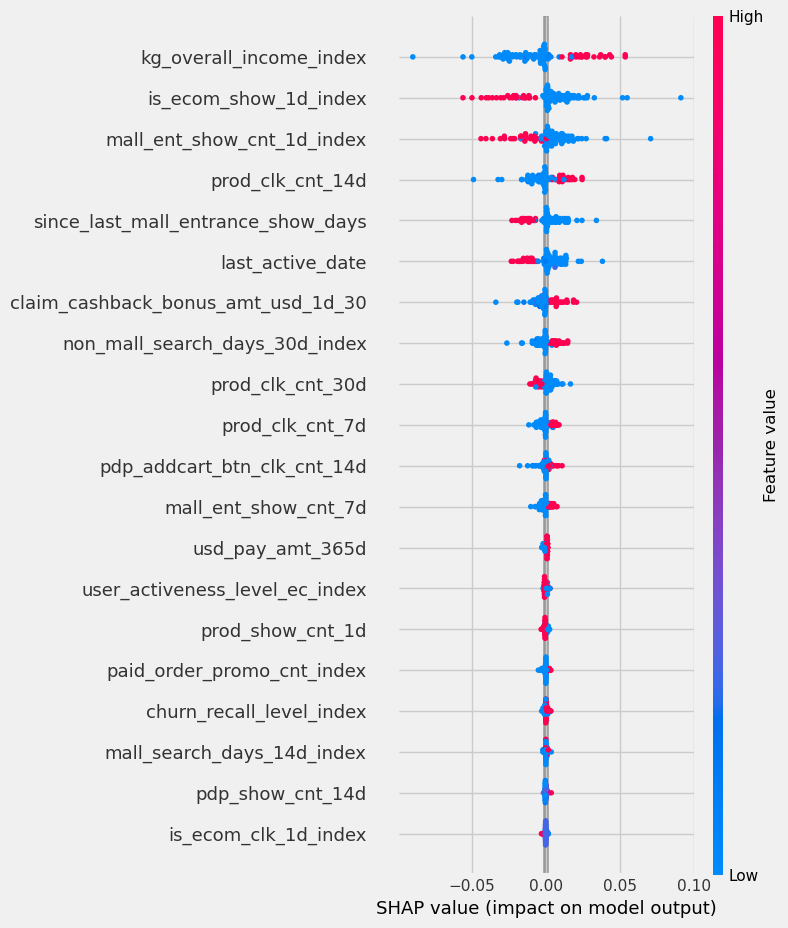

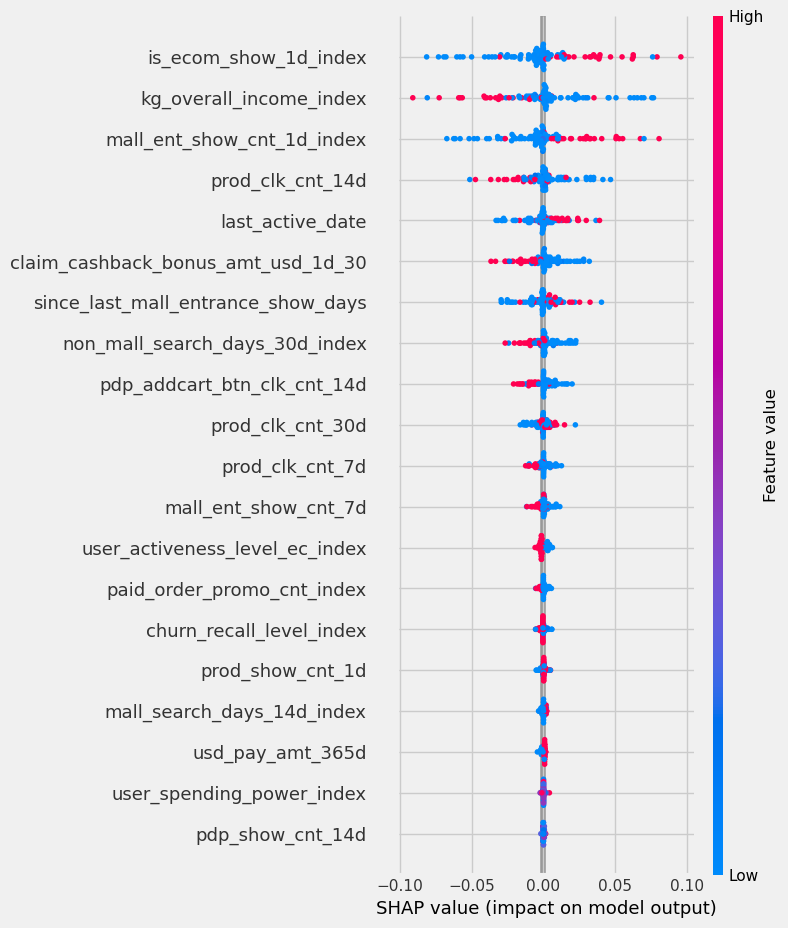

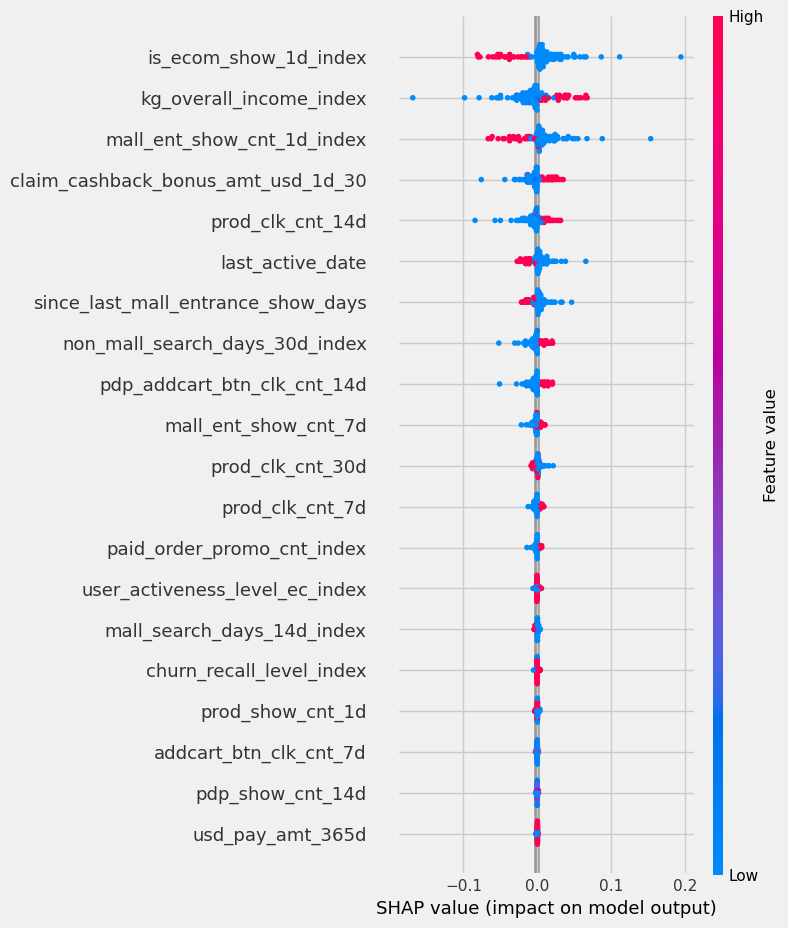

In [12]:
df_train = train_df.sample(n=100)
df_test = test_df.sample(n=100)

for treatment in [1,2,3]:
    model = model_list['Tarnet_256']
    feature_importance_with_shap(model, df_train,df_test,feature_list,feature_list_discrete,device,treatment)
